## Inference with SMURFF

In this notebook we will continue on the first example. After running a training trainSession again in SMURFF, we will look deeper into how to use SMURFF for making predictions. The full Python API for predictions is available in [Python API Reference » Inference](../api/inference.html).

To make predictions we recall that the value of a tensor model is given by a tensor contraction of all latent matrices. Specifically, the prediction for the element $\hat{Y}_{ijk}$ of a rank-3 tensor is given by

$$   \hat{Y}_{ijk} = \sum_{d=1}^D u^{(1)}_{d,i} u^{(2)}_{d,j} u^{(3)}_{d,k} + mean $$

Since a matrix is a rank-2 tensor the prediction for a matrix is given by:

$$   \hat{Y}_{ij} = \sum_{d=1}^D u^{(1)}_{d,i} u^{(2)}_{d,j} + mean $$

These inner products are computed by SMURFF automagicaly, as we will see below.

### Saving models

We run a `Macau` training trainSession using side information (`ecfp`) from the chembl dataset.
We make sure we *save every 10th sample*, such that we can load the model afterwards. This run will take some minutes to run.

In [1]:
import smurff
import os
import logging

ic50_train, ic50_test, ecfp = smurff.load_chembl()

# limit to 100 rows and 100 features to make thinks go faster
ic50_train = ic50_train.tocsr()[:100,:]
ic50_test = ic50_test.tocsr()[:100,:]
ecfp = ecfp.tocsr()[:100,:].tocsc()[:,:100]

trainSession = smurff.MacauSession(
                       Ytrain     = ic50_train,
                       Ytest      = ic50_test,
                       side_info  = [ecfp, None],
                       num_latent = 16,
                       burnin     = 200,
                       nsamples   = 100,
                       save_freq  = 10,
                       save_name  = "ic50-macau.hdf5",
                       verbose    = 2,)

predictions = trainSession.run()

### Saved Model

The model is saved in an HDF5 file, in this case `ic50-macau.hdf5`.
The file contains all saved info from this training run. For example:

In [2]:
%%bash

h5ls -r ic50-macau.hdf5

/                        Group
/config                  Group
/config/options          Group
/config/side_info_0      Group
/config/side_info_0/data Group
/config/side_info_0/data/data Dataset {10}
/config/side_info_0/data/indices Dataset {10}
/config/side_info_0/data/indptr Dataset {101}
/config/test             Group
/config/test/data        Group
/config/test/data/data   Dataset {78}
/config/test/data/indices Dataset {78}
/config/test/data/indptr Dataset {101}
/config/train            Group
/config/train/data       Group
/config/train/data/data  Dataset {336}
/config/train/data/indices Dataset {336}
/config/train/data/indptr Dataset {101}
/sample_10               Group
/sample_10/latents       Group
/sample_10/latents/latents_0 Dataset {100, 16}
/sample_10/latents/latents_1 Dataset {346, 16}
/sample_10/link_matrices Group
/sample_10/link_matrices/link_matrix_0 Dataset {100, 16}
/sample_10/link_matrices/link_matrix_1 Dataset {0, 0}
/sample_10/link_matrices/mu_0 Dataset {1, 16}
/sampl

The structure of the HDF5 file is:

- Datasets in `/config` contain the input data and configuration provided to the `TrainSession`
- The different `/sample_*` datasets contain for each posterior sample:
  - Predictions for the provided test matrix:
    - `predictions/pred_1sample`: Predictions from this sample
    - `predictions/pred_avg`: Predictions average across this and all previous samples
    - `predictions/pred_var`: Predictions variance across this and all previous samples
  - `latents_*`: Latent samples for each dimension
  - `link_matrices/`: When sideinfo is used with the `MacauPrior`, this HDF5 group contains the ß link 
     matrix, and the µ HyperPrior sample. This will allow to make predictions from unseen sideinfo.

Sparse matrices and tensors are stored using the [h5sparse-tensor Python package](https://pypi.org/project/h5sparse-tensor/) which is automatically installed as a dependency of smurff.


### Making  predictions from a `TrainSession`

The easiest way to make predictions is from an existing `TrainSession`:

In [3]:
predictor = trainSession.makePredictSession()
print(predictor)

PredictSession with 10 samples
  Data shape = (100, 346)
  Beta shape = [100, 0]
  Num latent = 16



Once we have a `PredictSession`, there are serveral ways to make predictions:

 * From a sparse matrix
 * For all possible elements in the matrix (the complete $U \times V$)
 * For a single point in the matrix
 * Using only side-information
 
#### Predict all elements

We can make predictions for all rows $\times$ columns in our matrix

In [4]:
p = predictor.predict_all()
print(p.shape) # p is a numpy array of size: (num samples) x (num rows) x (num columns)

(10, 100, 346)


#### Predict element in a sparse matrix
We can make predictions for a sparse matrix, for example our `ic50_test` matrix:

In [5]:
p = predictor.predict_some(ic50_test)
print(len(p),"predictions") # p is a list of Predictions
print("predictions 1:", p[0])

78 predictions
predictions 1: (45, 25): 5.23 | 1sample: 5.38 | avg: 4.68 | var: 10.27 | all: [5.466994278657815, 3.556934172336413, 4.37329279469418, 4.558447762178166, 5.518760768949337, 6.568628742127763, 3.8535251055402338, 3.001246710033499, 4.55148513380182, 5.383614751396357] 


#### Predict just one element

Or just one element. Let's predict the first element of our `ic50_test` matrix:

In [6]:
from scipy.sparse import find
(i,j,v) = find(ic50_test)
p = predictor.predict_one((i[0],j[0]),v[0])
print(p)

(45, 25): 5.23 | 1sample: 5.38 | avg: 4.68 | var: 10.27 | all: [5.466994278657815, 3.556934172336413, 4.37329279469418, 4.558447762178166, 5.518760768949337, 6.568628742127763, 3.8535251055402338, 3.001246710033499, 4.55148513380182, 5.383614751396357] 


And plot the histogram of predictions for this element.

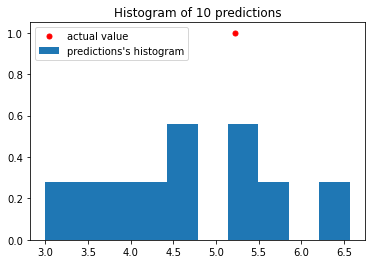

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot a histogram of the samples.
plt.subplot(111)
plt.hist(p.pred_all, bins=10, density=True, label = "predictions's histogram")
plt.plot(p.val, 1., 'ro', markersize =5, label = 'actual value')
plt.legend()
plt.title('Histogram of ' + str(len(p.pred_all)) + ' predictions')
plt.show()

#### Make predictions using side information

We can make predictions for rows/columns not in our train matrix, using only side info:

In [8]:
import numpy as np
from scipy.sparse import find

(i,j,v) = find(ic50_test)
row_side_info = ecfp.tocsr().getrow(i[0])
p = predictor.predict_one((row_side_info,j[0]),v[0])
print(p)

(<1x100 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>, 25): 5.23 | 1sample: 5.70 | avg: 5.24 | var: 5.97 | all: [5.647882865944923, 4.766097758946924, 4.938653156555175, 5.266514371433109, 5.774834514927121, 6.55942247076019, 4.685191103644728, 3.55286488638509, 5.552266183626731, 5.697722460389924] 


The two examples above give a matrix (rank-2 tensor) as a result. It is adviced
to make predictions on **all** samples, and average the predictions.

### Making predictions from saved run

One can also make a `PredictSession` from a saved HDF5 file:

In [10]:
import smurff

predictor = smurff.PredictSession("ic50-macau.hdf5")
print(predictor)

PredictSession with 10 samples
  Data shape = (100, 346)
  Beta shape = [100, 0]
  Num latent = 16
